In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra, operators, adaptive
from pyiga import algebra_cy, ieti_cy

from scipy.sparse.linalg import aslinearoperator as LinOp

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
class IetiMapper:
    def __init__(self, M, dir_data, neu_data=None, elim=False):
        self.mesh = M
        self.numpatches = self.mesh.numpatches
        self.elim=bool(elim)
        self.Constr={}
        self.nConstr = 0

        self.intfs = set()
        self.L_intfs = {}

        #self.n = [tuple([kv.numdofs for kv in kvs]) for ((kvs,_),_) in self.mesh.patches]
        self.N = [np.prod([kv.numdofs for kv in kvs]) for ((kvs,_),_) in self.mesh.patches]
        self.N_ofs = np.concatenate(([0], np.cumsum(self.N)))
        self.numdofs = self.N_ofs[-1]

        for ((p1,bd1,s1),((p2,bd2,s2),flip)) in self.mesh.interfaces.items():
            if ((p2,bd2,s2),(p1,bd1,s1),flip) not in self.intfs:
                self.intfs.add(((p1,bd1,s1),(p2,bd2,s2),flip))
            
        C=[self.computeInterfaceJump(p1, (assemble.int_to_bdspec(bd1),), s1 , p2, (assemble.int_to_bdspec(bd2),), s2, flip) for ((p1,bd1,s1),(p2,bd2,s2), flip) in self.intfs.copy()]
        if len(C)!=0:
            self.B = scipy.sparse.vstack(C)

        for (p,b,_),(p2,b2,_),flip in self.intfs:
            if (p,b) not in self.L_intfs:
                self.L_intfs[(p,b)]=[(p2,b2)]
            else:
                self.L_intfs[(p,b)].append((p2,b2))

        kvs = self.mesh.kvs
        geos = self.mesh.geos

        self.dir_idx = dict()
        self.dir_vals = dict()
        self.free = [np.arange(self.N[p]) for p in range(self.numpatches)]

        for key in dir_data:
            for p,b in self.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], [(b//2,b%2)], dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(np.concatenate(self.dir_idx[p]), return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
            self.free[p] = np.setdiff1d(self.free[p],self.dir_idx[p],assume_unique=True)
            
        self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])
        self.global_free = np.setdiff1d(np.arange(self.N_ofs[-1]),self.global_dir_idx, assume_unique=True)

        self.corners = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=True)+self.N_ofs[p] for p, kvs in enumerate(self.mesh.kvs)])

        # if self.elim:
        #     p_intfs = np.array([[p1,p2] for (p1,_,_),(p2,_,_),_ in self.intfs], dtype=np.int32).T
        #     Basis = algebra_cy.pyx_compute_basis(B.shape[0], B.shape[1], B, maxiter=10)
        #     self.Basis, self.N_ofs, self.N, B = ieti_cy.pyx_compute_decoupled_coarse_basis(Basis.tocsc(), self.N_ofs.astype(np.int32), p_intfs)
        
        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.numpatches)]
        nnz_per_col = self.B.getnnz(axis=0)
        # self.intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.global_dir_idx)
        self.skeleton = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.global_dir_idx)
        self.interior = np.setdiff1d(np.where(nnz_per_col == 0)[0], self.global_dir_idx)
        
        self.R_interior = self.numpatches*[None] ###TODO: without loops
        self.R_skeleton = self.numpatches*[None]
        self.R_interfaces = {}
        
        for p in range(self.numpatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask_skeleton = np.zeros(self.N[p], dtype=bool)
            intfs = np.where(self.Bk[p].getnnz(0) > 0)[0]
            mask_interior = np.ones(self.N[p], dtype=bool)
            mask_interior[intfs]=False
            if p in self.dir_idx:
                mask_interior[self.dir_idx[p]]=False
            self.R_interior[p]=Id[mask_interior,:][:,self.free[p]]
            for b in range(4):
                if not any([(p,b) in self.mesh.outer_boundaries[key] for key in self.mesh.outer_boundaries]):
                    mask_intf = np.zeros(self.N[p], dtype=bool)
                    interface_dofs = assemble.boundary_dofs(kvs[p],bdspec=[(b//2,b%2)],ravel=True)
                    mask_intf[interface_dofs[1:-1]] = True
                    mask_skeleton[interface_dofs] = True
                    if p in self.dir_idx:
                        mask_intf[self.dir_idx[p]]=False
                        mask_skeleton[self.dir_idx[p]]=False

                    self.R_interfaces[(p,b)] = Id[mask_intf,:][:,self.free[p]]
            self.R_skeleton[p] = Id[mask_skeleton,:][:,self.free[p]]

        # self.N -= np.array([len(self.dir_idx[p]) if p in self.dir_idx else 0 for p in range(self.numpatches)])
        # self.N_ofs = np.concatenate(([0], np.cumsum(self.N)))
        # self.B = self.B[:,self.global_free]
        # self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.numpatches)]
        
    def assemble(self, a, f):
        if self.elim:
            A = [self.Basis.T @ assemble.assemble('a * inner(grad(u), grad(v)) * dx', kvs, a=a[self.mesh.patch_domains[k]], bfuns=[('u',1), ('v',1)], geo=geo) @ self.Basis for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
            RHS = [self.Basis.T @ assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f[self.mesh.patch_domains[k]]).ravel() for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
        else:
            A = [assemble.assemble('a * inner(grad(u), grad(v)) * dx', kvs, a=a[self.mesh.patch_domains[k]], bfuns=[('u',1), ('v',1)], geo=geo) for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
            RHS = [assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f[self.mesh.patch_domains[k]]).ravel() for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
        
        self.BCRestr = {p:assemble.RestrictedLinearSystem(A[p], RHS[p], (self.dir_idx[p],self.dir_vals[p])) for p in self.dir_idx}
        RHS = [rhs if p not in self.dir_idx else self.BCRestr[p].b for p, rhs in enumerate(RHS)]
        A = [a if p not in self.dir_idx else self.BCRestr[p].A for p, a in enumerate(A)]

        return A, RHS

    def ConstraintMatrices(self, redundant = False):
        eliminated_constraints = np.repeat(False, self.B.shape[0])
        if not redundant:
            eliminated_constraints = (self.B[:,self.corners].getnnz(1)==2)

        B = self.B[:,self.global_free]

        eliminated_constraints = eliminated_constraints | (B.getnnz(1)==0)
        B = B[~eliminated_constraints,:]
        ofs = np.cumsum([0]+[len(x) for x in self.free])
        return [B[:,ofs[p]:ofs[p+1]] for p in range(self.numpatches)], eliminated_constraints

    def computeInterfaceJump(self, p1, bdspec1, s1, p2, bdspec2, s2, flip=None):
        """Join the dofs lying along boundary `bdspec1` of patch `p1` with
        those lying along boundary `bdspec2` of patch `p2`. 

        See :func:`compute_dirichlet_bc` for the format of the boundary
        specification.

        If `flip` is given, it should be a sequence of booleans indicating for
        each coordinate axis of the boundary if the coordinates of `p2` have to
        be flipped along that axis.
        """
        kvs1, kvs2 = self.mesh.patches[p1][0][0], self.mesh.patches[p2][0][0]
        if flip is None:
            flip=(self.sdim-1)*(False,)
        
        bkv1 = assemble.boundary_kv(kvs1, bdspec1)
        bkv2 = assemble.boundary_kv(kvs2, bdspec2, flip=flip) 
        
        #retrieve local dofs for each patch on the boundary
        dofs1 = assemble.boundary_dofs(self.mesh.patches[p1][0][0], bdspec1, ravel=True)
        dofs2 = assemble.boundary_dofs(self.mesh.patches[p2][0][0], bdspec2, ravel=True, flip=flip)
                
        #check for hierarchy of the boundary knot vectors. currently only supports knot vectors with equal degree.
        if all([bspline.is_sub_space(kv1,kv2) for kv1, kv2 in zip(bkv1,bkv2)]):
            pass
        elif all([bspline.is_sub_space(kv2,kv1) for kv1, kv2 in zip(bkv1,bkv2)]):      
            self.intfs.remove(((p1,2*bdspec1[0][0]+bdspec1[0][1],s1),(p2,2*bdspec2[0][0]+bdspec2[0][1],s2),flip))
            self.intfs.add(((p2,2*bdspec2[0][0]+bdspec2[0][1],s2),(p1,2*bdspec1[0][0]+bdspec1[0][1],s1),flip))
            p1, p2 = p2, p1
            bdspec1, bdspec2 = bdspec2, bdspec1
            bkv1, bkv2 = bkv2, bkv1
            dofs1, dofs2 = dofs2, dofs1
        else:
            #print(p1, bkv1, p2, bkv2)
            print('Interface coupling not possible between patch '+ str(p1) +' and patch '+str(p2)+'!')    

        self.Constr[(p1,p2)]=self.nConstr+np.arange(len(dofs2))
        self.nConstr+=len(dofs2)
            
        #Prolongation operator  
        P = -scipy.sparse.coo_matrix(bspline.prolongation_tp(bkv1,bkv2))   #TODO: make parameter to generate prolongation matrix as coo_matrix directly?
        
        #construct constraints for this interface
        data = np.concatenate([P.data, np.ones(len(dofs2))])
        I = np.concatenate([P.row, np.arange(len(dofs2))])
        J = np.concatenate([dofs1[P.col] + self.N_ofs[p1],dofs2 + self.N_ofs[p2]])
        A = scipy.sparse.coo_matrix((data,(I,J)),(len(dofs2), self.N_ofs[-1])).tocsr()
        return A
        
    def nodes_as_primals(self, dir_boundary=False):  ###TODO: cythonize(?)
        """Get global vertices of the multipatch object as well as local nodal degrees of freedom corresponding to the vertices. 
        In case of T-junctions also obtain the $p$ global degrees of freedom and $p$ local degrees of freedom on the coarse patch.
        Additionally may include nodes on the Dirichlet boundary if desired."""
        n = self.N_ofs[-1]

        idx = (self.B[:,self.corners]>0).getnnz(1)>0
        B = self.B[idx,:]
        B = B[B.getnnz(1)==2,:]
        loc_c = np.unique(B.indices)
        R = scipy.sparse.coo_matrix((np.ones(len(loc_c)),(np.arange(len(loc_c)),loc_c)),shape=(len(loc_c),n)).tocsr()
        c_B = B@R.T
        #print(c_B.toarray())

        R = scipy.sparse.coo_matrix((np.ones(len(loc_c)),(np.arange(len(loc_c)),loc_c)),shape=(len(loc_c),n)).tocsr()
        nodal_indicator = algebra_cy.pyx_compute_basis(c_B.shape[0], c_B.shape[1], c_B, maxiter=10)
        #print(nodal_indicator.toarray())
        
        dofs = np.empty(nodal_indicator.shape[1], dtype=np.int32)
        S = c_B.sum(0).A[0]
        for j in range(nodal_indicator.shape[1]):
            ind = nodal_indicator.indices[nodal_indicator.indptr[j]:nodal_indicator.indptr[j+1]]
            dofs[j]=R.indices[ind[np.argmax(S[ind])]]
        nodal_indicator = (R.T@nodal_indicator)[:,nodal_indicator.getnnz(axis=0)>1]
        nnz = self.B.getnnz(1)
        B = self.B.tocsc()
        constr = np.repeat(-1,len(dofs))

        for j in range(nodal_indicator.shape[1]):
            dof=dofs[j]
            for r in range(B.indptr[dof],B.indptr[dof+1]):
                i=B.indices[r]
                if nnz[i]>2:
                    constr[j]=i
                    break

        if any(constr!=-1):
            idx = np.where(constr!=-1)[0]
            res = scipy.sparse.csc_matrix(nodal_indicator.shape)
            Q = scipy.sparse.coo_matrix((np.ones(len(idx)),(idx,np.arange(len(idx)))),(len(constr),len(idx)))
            res = (Q@abs(self.B[constr[idx],:])).T
            res.data=res.data-1
            res.eliminate_zeros()
            res.data=res.data+1
            nodal_indicator += res

        q = np.ones(self.N_ofs[-1])
        q[self.global_dir_idx]=0
        nodal_indicator=scipy.sparse.spdiags(q,0,self.N_ofs[-1],self.N_ofs[-1])@nodal_indicator
        nodal_indicator = nodal_indicator[:,nodal_indicator.getnnz(0)>1]
        return nodal_indicator
        
    #def averages_as_primals(self):

    def completeDirichlet(self, U):
        return [self.BCRestr[p].complete(u) if p in self.BCRestr else u for p,u in enumerate(U)]

In [3]:
class PrimalSystem():
    def __init__(self, Prim):
        self.Prim = Prim
        self.nPrim = self.Prim.shape[1]

        self.Psi = scipy.sparse.csc_matrix((0,self.nPrim))
        self.A_prim = np.zeros(2*(self.nPrim,))
        self.RHS_prim = np.zeros(self.nPrim)
        self.R = []

    def incorporate_PrimalConstraints(self, A, B, RHS, IMap):
        self.nLagrangeMultipliers = B[0].shape[0]
        if self.nPrim == 0:
            return A, B, RHS
        K = len(A)
        C=[]
        for p in range(K):
            c = (self.Prim[IMap.N_ofs[p]:IMap.N_ofs[p+1],:].T).tocsr()
            jj = np.where((c.indptr[1:]-c.indptr[:-1])>0)[0]
            c = c[:,IMap.free[p]]
            c = c[c.getnnz(1)>0,:]
            C.append(c)
            self.R.append(scipy.sparse.coo_matrix((np.ones(c.shape[0]),(np.arange(c.shape[0]),jj)),(c.shape[0],self.nPrim)))
            
        self.nPrimConstr = [c.shape[0] for c in C]

        mod_A = [scipy.sparse.bmat([[A[p],C[p].T],[C[p], None]]) for p in range(K)]
        mod_RHS = [np.concatenate([RHS[p],np.zeros(self.nPrimConstr[p])]) for p in range(K)]

        mod_B = [scipy.sparse.hstack([B[p],scipy.sparse.csr_matrix((self.nLagrangeMultipliers, self.nPrimConstr[p]))]) for p in range(K)]
        return mod_A, mod_B, mod_RHS, C
        
    def compute_PrimalBasis(self, mod_A, mod_B, mod_RHS):
        loc_solver=[solvers.make_solver(a, spd=False, symmetric=True) for a in mod_A]
        self.Psi = []
        Delta = []
        self.B_prim = np.zeros((self.nLagrangeMultipliers,self.nPrim))
        for p in range(len(mod_A)):
            RHS = scipy.sparse.vstack([scipy.sparse.csr_matrix((loc_solver[p].shape[0]-self.nPrimConstr[p],self.nPrimConstr[p])), scipy.sparse.identity(self.nPrimConstr[p])]).toarray()
            sol = loc_solver[p]@RHS
            psi, delta = sol[:(-self.nPrimConstr[p]),], sol[(-self.nPrimConstr[p]):,]
            if psi.ndim==1: psi=psi[:,None]
            if delta.ndim==1: delta=delta[:,None]
            Delta.append(delta)
            self.Psi.append(psi@self.R[p])
            self.A_prim -= self.R[p].T@delta@self.R[p]
            self.B_prim += mod_B[p][:,:-self.nPrimConstr[p]]@self.Psi[-1]
            self.RHS_prim += self.Psi[-1].T@mod_RHS[p][:-self.nPrimConstr[p]]
        return loc_solver

    def distributePrimalSolution(self, u):
        u_prim = u[-1]
        return [u[p]+self.Psi[p]@u_prim for p in range(len(u)-1)]

    def PrimalSolution(self, u_prim):
        return [psi@u_prim for psi in self.Psi]
        

In [4]:
class IetiSystem():
    def __init__(self, A, B ,RHS, N, loc_solver = None, spd=False, symmetric=False):
        self.A = A
        self.B = B
        self.RHS = RHS
        self.N = N

        if loc_solver:
            assert len(loc_solver)==len(A), 'amount of local solvers does not match amount of local system matrices!'
            self.loc_solver=loc_solver
        else:
            self.loc_solver = [solvers.make_solver(a, spd=spd, symmetric=symmetric) for a in self.A]

        self.sanity_check()
        self.K = len(A)
        self.nLagrangeMultipliers = self.B[0].shape[0]

    def SaddlePointSystem(self, format='coo'):
        B = scipy.sparse.hstack(self.B)
        return scipy.sparse.bmat([[scipy.sparse.block_diag(self.A),B.T],[B,None]], format=format)

    def RHSforSaddlePointSystem(self):
        return np.concatenate(self.RHS+[np.zeros(self.nLagrangeMultipliers)])

    def SchurComplement(self, as_matrix=False):
        F = operators.SumOperator([LinOp(self.B[p])@self.loc_solver[p]@LinOp(self.B[p].T) for p in range(self.K)])
        if as_matrix:
            return F@np.eye(F.shape[1])
        return F

    def RHSforSchurComplement(self):
        return np.sum([self.B[p]@(self.loc_solver[p]@self.RHS[p]) for p in range(self.K)], axis=0)

    def constructSolutionFromLagrangeMultipliers(self, lam):
        return [(self.loc_solver[p]@(self.RHS[p]-self.B[p].T@lam))[:self.N[p]] for p in range(self.K)]
        
    def sanity_check(self):
        assert len(A)==len(B)==len(RHS), 'Length of input data incompatible!'
        K = len(A)
        assert np.all([B[0].shape[0]==B[p].shape[0] for p in range(K)]), 'Constraint matrices have incompatible number of constraints!'
        assert np.all([self.A[p].shape[0]==self.A[p].shape[1] for p in range(K)]), 'Local system matrices are not square!'
        assert np.all([self.B[p].shape[1] == self.A[p].shape[1] for p in range(K)]), 'Constraint matrices have incompatible dimension!'
        assert np.all([self.A[p].shape[0]==len(self.RHS[p]) for p in range(K)]), 'Local rhs vectors have incompatible dimension!'

In [5]:
from scipy.sparse.linalg import aslinearoperator as LinOp
    
class ScaledDirichletPreconditioner():
    def __init__(self, A ,B, IMap, a=None):
        self.A = A
        self.IMap = IMap
        self.K   = len(B)

        self.B   = [B[p]@IMap.R_skeleton[p].T for p in range(len(B))]

        self.N_ofs = np.cumsum([0]+[b.shape[1] for b in self.B])

        self.D = []
        self.S = [LinOp(IMap.R_skeleton[p]@A[p]@IMap.R_skeleton[p].T) - 
                  LinOp(IMap.R_skeleton[p]@A[p]@IMap.R_interior[p].T)
                  @solvers.make_solver(IMap.R_interior[p]@A[p]@IMap.R_interior[p].T, spd=True)
                  @LinOp(IMap.R_interior[p]@A[p].T@IMap.R_skeleton[p].T) for p in range(self.K)]

    def SchurMatrices(self):
        return [s@np.eye(s.shape[0]) for s in self.S]

    def setupMultiplicityScaling(self):
        B = [None]*len(self.B)
        for p in range(len(self.B)):
            B[p]=self.B[p].copy()
            B[p].data[abs(B[p].data)<1-1e-12]=0
            B[p].eliminate_zeros()
        self.D = [scipy.sparse.diags(1/(1+b.getnnz(0)), format='csr') for b in B]
        
    def setupConstraintScaling(self):
        self.D = [scipy.sparse.diags(1/(1+b.getnnz(0)), format='csr') for b in self.B]

    def setupWeightScaling(self):
        self.D = [scipy.sparse.diags(1/(1+abs(b).sum(0).A.flatten()), format='csr') for b in self.B]
        
    def setupCoefficientScaling(self, a):
        self.D = [scipy.sparse.csr_array((self.B[p].shape[1],self.B[p].shape[1])) for p in range(self.K)]
        for (p1,b1) in self.IMap.L_intfs:
            R1 = self.IMap.R_interfaces[(p1,b1)]@self.IMap.R_skeleton[p1].T
            for (p2,b2) in self.IMap.L_intfs[(p1,b1)]:
                R2 = self.IMap.R_interfaces[(p2,b2)]@self.IMap.R_skeleton[p2].T
                a1, a2 = a[self.IMap.mesh.patch_domains[p1]], a[self.IMap.mesh.patch_domains[p2]]
                self.D[p1] += (a2)/(a1+a2)*R1.T@scipy.sparse.identity(R1.shape[0])@R1
                self.D[p2] += (a1)/(a1+a2)*R2.T@scipy.sparse.identity(R2.shape[0])@R2
        
    def setupSelectionScaling(self, a):
        B = self._parametersort(self.B,a)
        #B = self.B
        self.D = [scipy.sparse.spdiags(1*((b.getnnz(0)==1) & (np.isclose(b.sum(0).A.flatten(),1))),0,b.shape[1],b.shape[1], format='csr') for b in B] 

    def setupDeluxeScaling(self):
        self.D = [np.zeros((self.B[p].shape[1],self.B[p].shape[1])) for p in range(self.K)]
        S = self.SchurMatrices()
        for (p1,b1) in self.IMap.L_intfs:
            R1 = self.IMap.R_interfaces[(p1,b1)]@self.IMap.R_skeleton[p1].T
            S1 = R1@S[p1]@R1.T
            for (p2,b2) in self.IMap.L_intfs[(p1,b1)]:
                R2 = self.IMap.R_interfaces[(p2,b2)]@self.IMap.R_skeleton[p2].T
                S2 = R2@S[p2]@R2.T
                Inv = np.linalg.inv(S1+S2)
                self.D[p1]+=R1.T@(Inv@S2)@R1
                self.D[p2]+=R2.T@(Inv@S1)@R2

    def _parametersort(self, B, a):
        N_ofs = np.cumsum([0]+[b.shape[1] for b in B])
        K = len(B)
        B = scipy.sparse.hstack(B)
        B.eliminate_zeros()
        a_int = {key:i for i,key in enumerate(a)}
        n=B.shape[0]
        idx = np.where((B.getnnz(1)==2) & np.isclose(B.sum(1).A.flatten(),0))[0]
        D = np.array([a_int[key] for key in self.IMap.mesh.patch_domains.values()], dtype=int)
        I = B[idx].indices.reshape(len(idx),2)
        P = np.array([p*((N_ofs[p]<= I) & (I < N_ofs[p+1])) for p in range(K)]).sum(axis=0)
        A = np.array(list(a_int.values()))
        R = A[D[P]]*B[idx].data.reshape(len(idx),2)[:,1][:,newaxis]
        switch = idx[R[:,0]<R[:,1]]
        q = np.ones(n)
        q[switch]=-1.
        return [scipy.sparse.spdiags(q,0,n,n)@b for b in self.B]
        
    def prec(self):
        assert len(self.D)==self.K, 'Not all scaling matrices given! Call a setup routine first!'
        BgD = [LinOp(self.B[p]@self.D[p]) for p in range(self.K)]
        #B = scipy.sparse.hstack(self.B)
        #print("Convergence condition: "+str(scipy.sparse.linalg.norm(B@scipy.sparse.block_diag(self.D).T@B.T@B-B)))
        return operators.SumOperator([BgD[p]@self.S[p]@BgD[p].T for p in range(self.K)])     

In [6]:
def MsD_deluxe_whole(IMap, S, B, C):
    S_ = [np.zeros(s.shape) for s in S]
    B_ = len(B)*[None]
    C_ = len(C)*[None]
    for p in range(IMap.numpatches):
        C_[p]=C[p]@IMap.R_skeleton[p].T
        B_[p] = scipy.sparse.hstack([B[p],scipy.sparse.csr_matrix((B[p].shape[0],C_[p].shape[0]))])
        for b in range(4):
            if (p,b) in IMap.R_interfaces:
                R = IMap.R_interfaces[(p,b)]@IMap.R_skeleton[p].T
                S_[p] += R.T@R@S[p]@R.T@R
        #print(S_[p].shape, C_[p].shape)
    return np.linalg.pinv(np.array([B_[p]@np.linalg.inv(scipy.sparse.block_array([[S_[p],C_[p].T],[C_[p],np.zeros(2*(C_[p].shape[0],))]]).toarray())@B_[p].T for p in range(len(S))]).sum(axis=0))

In [33]:
deg = 3
N = deg+1

knots = (bspline.make_knots(deg,0,1,N),bspline.make_knots(deg,0,1,N))
M = topology.PatchMesh([(knots,geometry.unit_square())])
#M.h_refine();

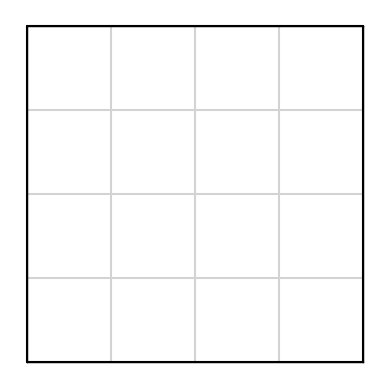

In [34]:
M.draw(knots=1);
plt.axis('off');

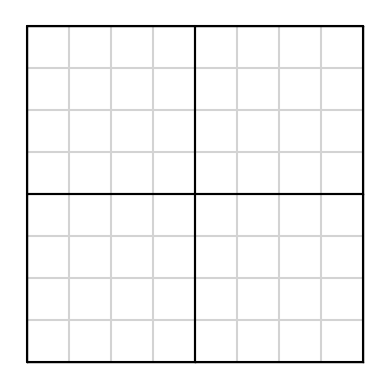

In [35]:
M.h_refine();
M.draw(knots=1);
plt.axis('off');

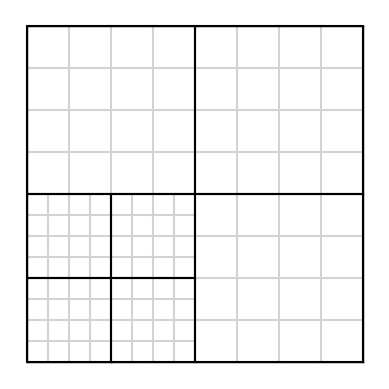

In [36]:
M.h_refine({0:None});
M.draw(knots=1);
plt.axis('off');

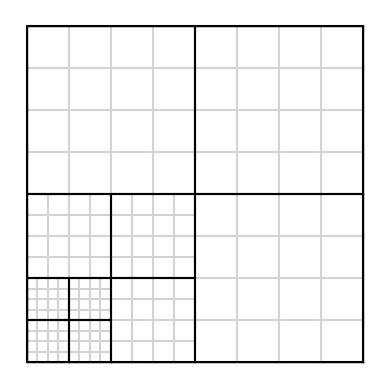

In [37]:
M.h_refine({0:None});
M.draw(knots=1);
plt.axis('off');

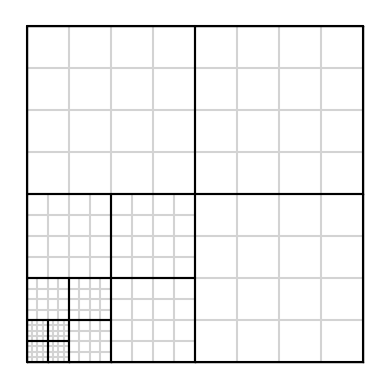

In [38]:
M.h_refine({0:None});
M.draw(knots=1);
plt.axis('off');

setting up constraints took 0.008671283721923828 seconds.
Basis setup took 0.0014681816101074219 seconds
Setting up Mapper took 0.4080617427825928 seconds.
Assembling took 0.06719970703125 seconds.
Computing jump matrices took 0.0005235671997070312 seconds.
Setting up primal system took 0.002174854278564453 seconds.
Setting up primal constraints took 0.004547834396362305 seconds.
Setting up primal basis and local solvers took 0.005555391311645508 seconds.
Setting up Schur system took 0.0005755424499511719 seconds.


pcg with preconditioned condition number κ ~ 17.38604249219176 stopped after 28 iterations with relres 9.369149291958042e-07 after 0.0041158199310302734 seconds.
#############################################################################################
Setting up multiplicity scaling took 0.0012230873107910156 seconds.
Convergence condition: 7.349521128185874
pcg with preconditioned condition number κ ~ 20101262.157662507 stopped after 43 iterations with relres 6.4377239

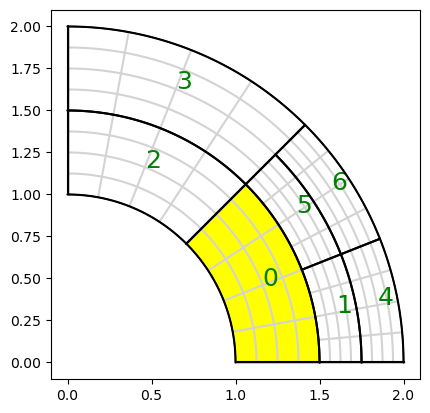

In [7]:
deg = 3
N = deg+1

knots = (bspline.make_knots(deg,0,1,N),bspline.make_knots(deg,0,1,N))
M = topology.PatchMesh([(knots,geometry.quarter_annulus())])
M.h_refine();

#M.set_domain_id({1:{0,3}})

#M.h_refine();
M.set_domain_id({1:{0}})
M.h_refine({1:None})

#M.h_refine({1:-1,0:-1})
# M.h_refine({1:-1,2:-1})
# M.h_refine({3:-1,2:-1})
#M.h_refine({0:-1,3:-1})

f={0:lambda x,y: 100., 1:lambda x,y: 100.}
a = {0:1.,1:1e6}
dir_data = {0:0}

M.draw(knots=1, patch_idx=1, color={0:"white", 1:"yellow"})
MP = assemble.Multipatch(M, automatch=True)

t = time.time()
IMap = IetiMapper(M, dir_data)
print('Setting up Mapper took '+str(time.time()-t)+' seconds.')
t =time.time()
A, RHS = IMap.assemble(a,f)
print('Assembling took '+str(time.time()-t)+' seconds.')
N = [a.shape[0] for a in A]
t=time.time()
B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
print('Computing jump matrices took '+str(time.time()-t)+' seconds.')

P = ScaledDirichletPreconditioner(A, B, IMap)

t=time.time()
primal = PrimalSystem(IMap.nodes_as_primals())
print('Setting up primal system took '+str(time.time()-t)+' seconds.')
t=time.time()
A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
print('Setting up primal constraints took '+str(time.time()-t)+' seconds.')
t=time.time()
loc_solver = primal.compute_PrimalBasis(A, B, RHS)
print('Setting up primal basis and local solvers took '+str(time.time()-t)+' seconds.')
A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), 
loc_solver.append(solvers.make_solver(primal.A_prim, spd=True)), N.append(primal.A_prim.shape[0])

t=time.time()
I = IetiSystem(A, B, RHS, N, loc_solver)
F, b = I.SchurComplement(), I.RHSforSchurComplement()
print('Setting up Schur system took '+str(time.time()-t)+' seconds.')

#F_mat = F@np.eye(F.shape[0])

print('\n')

lam0, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=True, rtol=1e-6, atol=1e-12)
print('#############################################################################################')

t=time.time()
P.setupMultiplicityScaling()
print('Setting up multiplicity scaling took '+str(time.time()-t)+' seconds.')
lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P.prec(), output=True, rtol=1e-6, atol=1e-12)
print('#############################################################################################')

t=time.time()
P.setupConstraintScaling()
print('Setting up constraint scaling took '+str(time.time()-t)+' seconds.')
lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P.prec(), output=True, rtol=1e-6, atol=1e-12)
print('#############################################################################################')

t=time.time()
P.setupWeightScaling()
print('Setting up weight scaling took '+str(time.time()-t)+' seconds.')
lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P.prec(), output=True, rtol=1e-6, atol=1e-12)
print('#############################################################################################')

t=time.time()
P.setupCoefficientScaling(a)
print('Setting up coefficient scaling took '+str(time.time()-t)+' seconds.')
lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P.prec(), output=True, rtol=1e-6, atol=1e-12)
print('#############################################################################################')

# t=time.time()
# P.setupDeluxeScaling()
# print('Setting up deluxe scaling took '+str(time.time()-t)+' seconds.')
# lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P.prec(), output=True, rtol=1e-6, atol=1e-12)
# print('#############################################################################################')

t=time.time()
P.setupSelectionScaling(a)
print('Setting up selection scaling took '+str(time.time()-t)+' seconds.')
lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P.prec(), output=True, rtol=1e-6, atol=1e-12)
print('#############################################################################################')

t=time.time()
Prec = MsD_deluxe_whole(IMap, P.SchurMatrices(), P.B, C)
print('Setting up edge scaling took '+str(time.time()-t)+' seconds.')
lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=Prec, output=True, rtol=1e-6, atol=1e-12)
print('#############################################################################################')

# u_delta = I.constructSolutionFromLagrangeMultipliers(lam0)[:-1]
# u_prim =primal.PrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam0)[-1])

# u_delta = np.concatenate(IMap.completeDirichlet(u_delta))
# u_prim = np.concatenate(IMap.completeDirichlet(u_prim))

# MP.plot(u_delta)
# MP.plot(u_prim)
# MP.plot(u_delta+u_prim)

In [9]:
def EdgePreconditioner(IMap, S, B):
    B_red, eliminated = IMap.ConstraintMatrices(redundant=True)
    B_red = [b[:,b.getnnz(0)>0] for b in B_red]
    MsD = np.zeros((B[0].shape[0],B[0].shape[0]))
    for (p1,b1) in IMap.L_intfs:
        R1 = IMap.R_interfaces[(p1,b1)]@IMap.R_skeleton[p1].T
        S1_inv = np.linalg.inv(R1@S[p1]@R1.T)
        for (p2,b2) in IMap.L_intfs[(p1,b1)]:
            R2 = IMap.R_interfaces[(p2,b2)]@IMap.R_skeleton[p2].T
            S2_inv=np.linalg.inv(R2@S[p2]@R2.T)
            B2 = B[p2]@R2.T
            B1 = B_red[p1]@R1.T
            B1 = B1[(B_red[p2]@R2.T).getnnz(1)>0,:]
            MsD+=B2@(S2_inv + B1@S1_inv@B1.T)@B2.T
    return MsD

In [80]:
degs = (2,3,5)
maxiter=4
R = np.zeros((maxiter,2*len(degs)))

f={0:lambda x,y: 100., 1:lambda x,y: 100.}
a = {0:1.,1:1000.}
dir_data = {0:0}

for i,deg in enumerate(degs):
    N = deg+1
    knots = (bspline.make_knots(deg,0,1,N),bspline.make_knots(deg,0,1,N))
    M = topology.PatchMesh([(knots,geometry.quarter_annulus())])
    M.h_refine()
    M.h_refine()
    M.set_domain_id({1:{0,1,2,3,6,9,12,15}})
    #M.h_refine({p:-1 for p in {0,1,2,3,6,9,12,15}})
    M.h_refine({p:-1 for p in {4,5,7,8,10,11,13,14}})

    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiter):
        print(k)
        n_p = MP.numpatches
        #M.draw(figsize=(5,5),color={1:'orange',0:'white'}, knots=1, bwidth=0.01, nodes=0)
        #plt.axis('off');
        #plt.axis('scaled');
        #plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
        #plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        ### IETI Mapper
        IMap = IetiMapper(M, dir_data)
        A, RHS = IMap.assemble(a=a,f=f)
        N = [A.shape[0] for A in A]
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=True)

        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        ### Set up primal system
        primal = PrimalSystem(IMap.nodes_as_primals())
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symmetric=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        F, b = I.SchurComplement(), I.RHSforSchurComplement()

        #lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=True, rtol=1e-6, atol=1e-12)
        
        #SD.setupSelectionScaling(a=a)
        P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P, output=True, rtol=1e-6, atol=1e-12)
        R[k,2*i] = abs(max_eig/min_eig)
        R[k,2*i+1] = it 

        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate([IMap.BCRestr[p].complete(u) if p in IMap.BCRestr else u for p,u in enumerate(u)])
        #print(len(u))
        #MP.plot(u)

        #err_ind=adaptive.mp_resPois(MP,u,a=a, f=f)

        #marked_patches = adaptive.doerfler_mark(err_ind, theta=0.9, TOL=0)
        #marked_patches = {p:None for p in marked_patches}

        M.h_refine(-1);

        print("#####################################################")
np.savetxt('checkerboard_badselection.txt', R, fmt=len(degs)*('%1.3f','%d'), delimiter = ' & ', newline='\\\\\n')

setting up constraints took 0.02118825912475586 seconds.
Basis setup took 0.0012996196746826172 seconds
deg = 2
0
setting up constraints took 0.0203399658203125 seconds.
Basis setup took 0.0012693405151367188 seconds
pcg with preconditioned condition number κ ~ 10.772920926851267 stopped after 15 iterations with relres 7.703775226908138e-07 after 0.00726008415222168 seconds.
#####################################################
1
setting up constraints took 0.03178000450134277 seconds.
Basis setup took 0.0018277168273925781 seconds
pcg with preconditioned condition number κ ~ 14.927611464890992 stopped after 17 iterations with relres 4.441100624212528e-07 after 0.011082887649536133 seconds.
#####################################################
2
setting up constraints took 0.037767648696899414 seconds.
Basis setup took 0.002216815948486328 seconds
pcg with preconditioned condition number κ ~ 19.707300772847244 stopped after 18 iterations with relres 7.313520499252634e-07 after 0.025372

KeyboardInterrupt: 

In [71]:
R

array([[ 7.77552, 13.     , 11.31575, 15.     , 17.6817 , 17.     ],
       [10.77712, 15.     , 15.33805, 17.     , 22.71833, 19.     ],
       [14.93362, 17.     , 20.165  , 18.     , 28.46631, 21.     ],
       [19.71171, 18.     , 25.6335 , 20.     , 34.82932, 24.     ],
       [25.12065, 20.     , 31.7131 , 22.     , 41.67529, 25.     ]])

In [9]:
def Heat_annulus(deg, N):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.quarter_annulus(),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine()

    M.set_domain_id({1:{0}})
    return M

In [16]:
f={0:lambda x,y: 100., 1:lambda x,y: 100.}
a = {0:1.,1:1000.}
dir_data = {0:0}

setting up constraints took 0.003618478775024414 seconds.
Basis setup took 0.001001119613647461 seconds
deg = 4
0


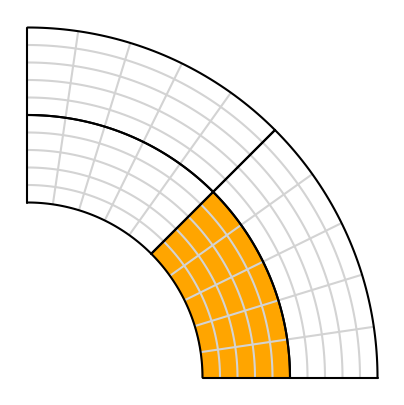

setting up constraints took 0.004377126693725586 seconds.
Basis setup took 0.0009975433349609375 seconds
pcg with preconditioned condition number κ ~ 4.3513798467870854 stopped after 7 iterations with relres 1.3862092304816472e-07 after 0.0024213790893554688 seconds.
Residual contributions took 0.018636465072631836 seconds.
Jump contributions took 0.01573967933654785 seconds.
#####################################################
1


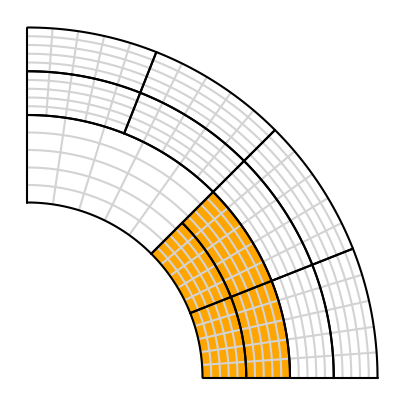

setting up constraints took 0.017377138137817383 seconds.
Basis setup took 0.0014843940734863281 seconds
pcg with preconditioned condition number κ ~ 1547.117333444613 stopped after 29 iterations with relres 6.524558497257756e-07 after 0.024266719818115234 seconds.
Residual contributions took 0.06082963943481445 seconds.
Jump contributions took 0.07545113563537598 seconds.
#####################################################
2


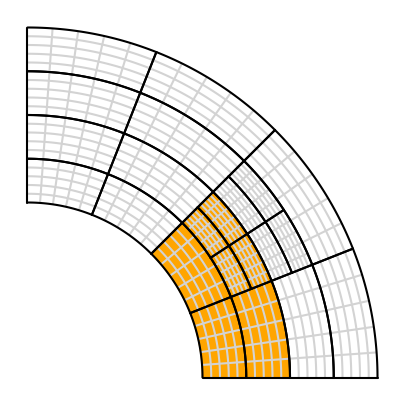

setting up constraints took 0.03440523147583008 seconds.
Basis setup took 0.001524209976196289 seconds
pcg with preconditioned condition number κ ~ 1989.705109162583 stopped after 37 iterations with relres 5.549118398551831e-07 after 0.05176544189453125 seconds.
Residual contributions took 0.10141777992248535 seconds.
Jump contributions took 0.1492326259613037 seconds.
#####################################################
3


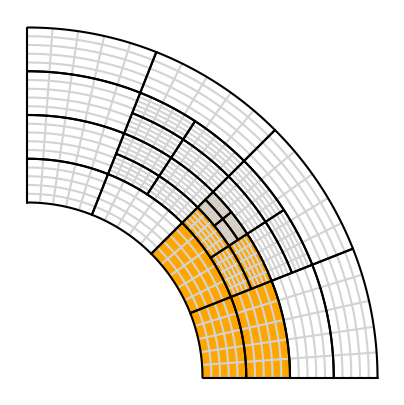

setting up constraints took 0.05200481414794922 seconds.
Basis setup took 0.0019519329071044922 seconds
pcg with preconditioned condition number κ ~ 3067.5360017564562 stopped after 53 iterations with relres 7.650619518533269e-07 after 0.10121560096740723 seconds.
Residual contributions took 0.14214324951171875 seconds.
Jump contributions took 0.2277054786682129 seconds.
#####################################################
4


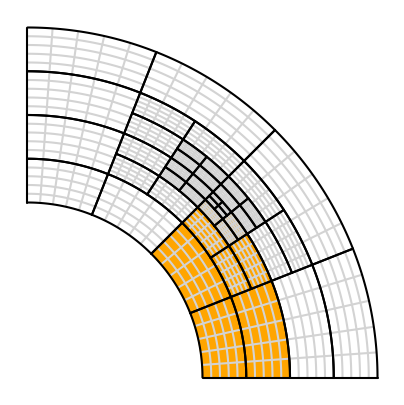

setting up constraints took 0.07432103157043457 seconds.
Basis setup took 0.002073049545288086 seconds
pcg with preconditioned condition number κ ~ 3090.377825878045 stopped after 58 iterations with relres 6.46789953727947e-07 after 0.1536862850189209 seconds.
Residual contributions took 0.19632911682128906 seconds.
Jump contributions took 0.3316824436187744 seconds.
#####################################################
5


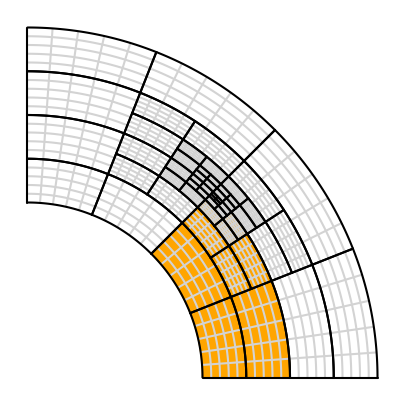

setting up constraints took 0.09715056419372559 seconds.
Basis setup took 0.0021543502807617188 seconds
pcg with preconditioned condition number κ ~ 3102.6065772228926 stopped after 60 iterations with relres 9.777620695825197e-07 after 0.20641303062438965 seconds.
Residual contributions took 0.25052833557128906 seconds.
Jump contributions took 0.4363901615142822 seconds.
#####################################################
6


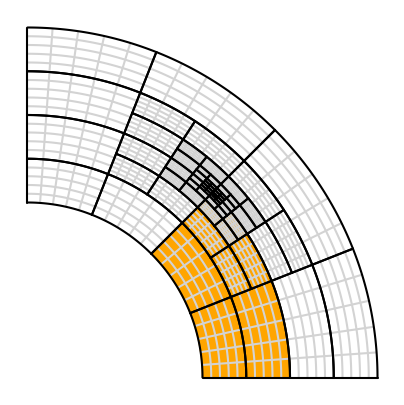

setting up constraints took 0.11879587173461914 seconds.
Basis setup took 0.0024137496948242188 seconds
pcg with preconditioned condition number κ ~ 3106.709755873501 stopped after 63 iterations with relres 6.91352412424356e-07 after 0.2691061496734619 seconds.
Residual contributions took 0.30766725540161133 seconds.
Jump contributions took 0.5435869693756104 seconds.
#####################################################
7


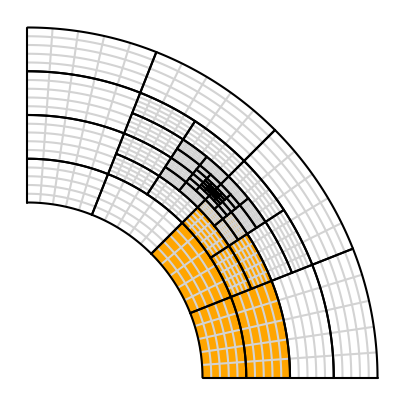

setting up constraints took 0.1433703899383545 seconds.
Basis setup took 0.0025115013122558594 seconds
pcg with preconditioned condition number κ ~ 3105.3878316748774 stopped after 63 iterations with relres 8.096914899644854e-07 after 0.3283357620239258 seconds.
Residual contributions took 0.36222028732299805 seconds.
Jump contributions took 0.8065075874328613 seconds.
#####################################################
8


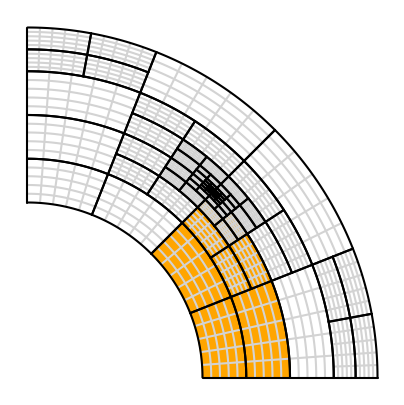

setting up constraints took 0.174591064453125 seconds.
Basis setup took 0.002818584442138672 seconds
pcg with preconditioned condition number κ ~ 3093.295082162687 stopped after 63 iterations with relres 8.46398425789013e-07 after 0.41985440254211426 seconds.
Residual contributions took 0.5685269832611084 seconds.
Jump contributions took 0.7926788330078125 seconds.
#####################################################
9


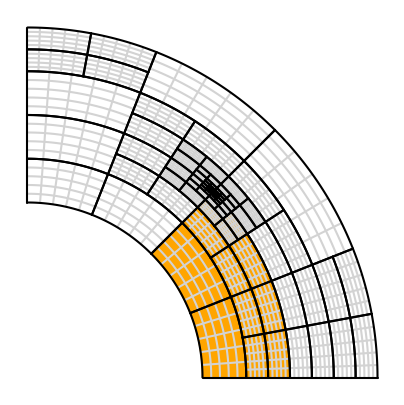

setting up constraints took 0.2067275047302246 seconds.
Basis setup took 0.003053903579711914 seconds
pcg with preconditioned condition number κ ~ 3078.61923681687 stopped after 66 iterations with relres 6.0392637950433e-07 after 0.5540118217468262 seconds.
Residual contributions took 0.5226001739501953 seconds.
Jump contributions took 0.9367244243621826 seconds.
#####################################################
10


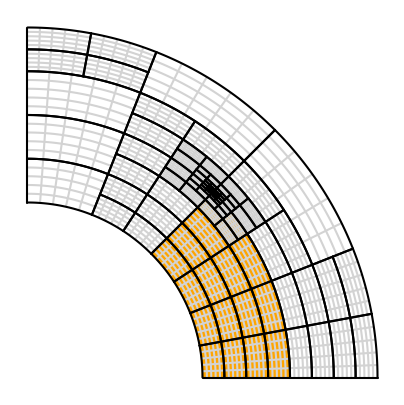

setting up constraints took 0.2459869384765625 seconds.
Basis setup took 0.003580331802368164 seconds
pcg with preconditioned condition number κ ~ 3054.973470762233 stopped after 66 iterations with relres 6.430413306525808e-07 after 0.6960902214050293 seconds.
Residual contributions took 0.6224708557128906 seconds.
Jump contributions took 1.1015057563781738 seconds.
#####################################################
11


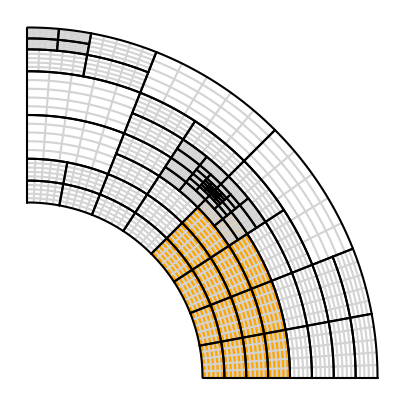

setting up constraints took 0.2770357131958008 seconds.
Basis setup took 0.003548860549926758 seconds
pcg with preconditioned condition number κ ~ 3046.9864143517875 stopped after 65 iterations with relres 6.960259546094592e-07 after 1.2255208492279053 seconds.
Residual contributions took 0.7155029773712158 seconds.
Jump contributions took 1.2445387840270996 seconds.
#####################################################
12


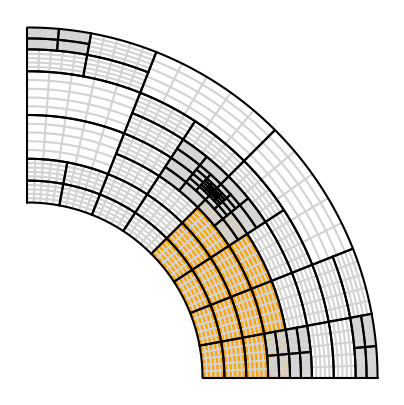

setting up constraints took 0.31354856491088867 seconds.
Basis setup took 0.0041217803955078125 seconds
pcg with preconditioned condition number κ ~ 3045.787824954721 stopped after 64 iterations with relres 7.988307127064745e-07 after 1.6055104732513428 seconds.
Residual contributions took 0.814507007598877 seconds.
Jump contributions took 1.422964334487915 seconds.
#####################################################
13


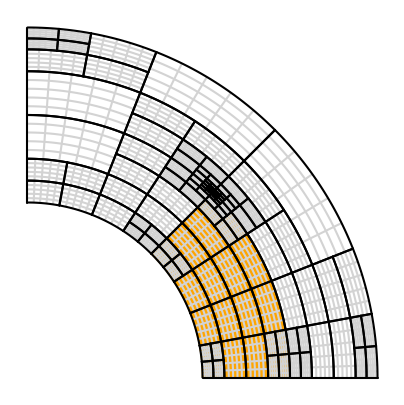

setting up constraints took 0.3490588665008545 seconds.
Basis setup took 0.004085063934326172 seconds
pcg with preconditioned condition number κ ~ 3070.078476034031 stopped after 65 iterations with relres 7.900329494445138e-07 after 1.7023231983184814 seconds.
Residual contributions took 0.9132423400878906 seconds.
Jump contributions took 1.6002957820892334 seconds.
#####################################################
14


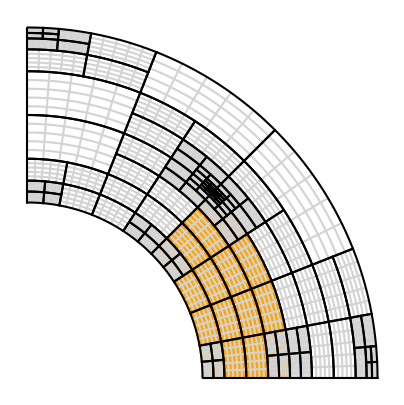

setting up constraints took 0.3912816047668457 seconds.
Basis setup took 0.00444340705871582 seconds
pcg with preconditioned condition number κ ~ 3079.1226939299186 stopped after 68 iterations with relres 3.899282710742939e-07 after 2.168205738067627 seconds.
Residual contributions took 1.000436544418335 seconds.
Jump contributions took 1.7736868858337402 seconds.
#####################################################
15


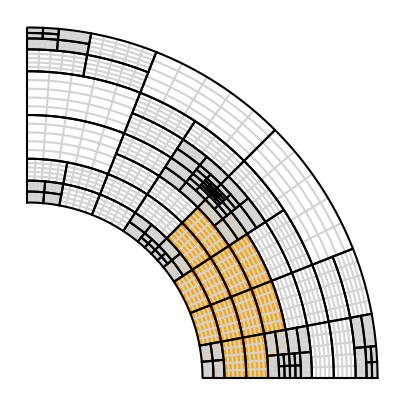

setting up constraints took 0.4373760223388672 seconds.
Basis setup took 0.004750490188598633 seconds


AssertionError: Not an H^1-conforming function space.

In [27]:
degs = (4,)
maxiter=20
R = np.zeros((maxiter,3*len(degs)))
for i,deg in enumerate(degs):
    N = deg+1
    M = Heat_annulus(deg,N)
    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiter):
        print(k)
        n_p = MP.numpatches
        M.draw(figsize=(5,5),color={1:'orange',0:'white'}, knots=1, bwidth=0.01, nodes=0)
        plt.axis('off');
        plt.axis('scaled');
        #plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
        plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        ### IETI Mapper
        IMap = IetiMapper(M, dir_data)
        A, RHS = IMap.assemble(a=a,f=f)
        N = [A.shape[0] for A in A]
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=True)

        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        ### Set up primal system
        primal = PrimalSystem(IMap.nodes_as_primals())
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symmetric=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        F, b = I.SchurComplement(), I.RHSforSchurComplement()

        #lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=True, rtol=1e-6, atol=1e-12)
        
        SD.setupSelectionScaling(a=a)
        #P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
        R[k,3*i] = n_p
        R[k,3*i+1] = abs(max_eig/min_eig)
        R[k,3*i+2] = it 

        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate([IMap.BCRestr[p].complete(u) if p in IMap.BCRestr else u for p,u in enumerate(u)])
        #MP.plot(u)

        err_ind=adaptive.mp_resPois(MP,u,a=a, f=f)

        marked_patches = adaptive.doerfler_mark(err_ind, theta=0.9, TOL=0)
        marked_patches = {p:None for p in marked_patches}

        M.h_refine(patches=marked_patches,ref="rs");

        # marked_patches = consistency_split(MP,a)
        # print(marked_patches)
        # M.h_refine(patches=marked_patches,ref="rs");
        # MP = assemble.Multipatch(M, automatch=True)

        print("#####################################################")

np.savetxt('singular_selection_consistency', R, fmt=len(degs)*('%d', '%1.3f','%d'), delimiter = ' & ', newline='\\\\\n')

In [9]:
def Inductor(deg,N):
    kvs=42*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    
    geos=[      
        geometry.unit_square().scale((0.5)).translate((-0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,-0.5)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,-0.5)),
        geometry.unit_square().scale(0.5).translate((1.5,-0.5)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0)),
        geometry.unit_square().scale(0.25),
        geometry.unit_square().scale(0.25).translate((0.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0)),
        
        geometry.unit_square().scale((0.5,0.025)).translate((-0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((1.5,0.25)),
        
        geometry.unit_square().scale((0.5,0.5)).translate((-0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((1.5,0.275)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0.775)),
        
        geometry.unit_square().scale(0.5).translate((-0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,1.025)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,1.025)),
        geometry.unit_square().scale(0.5).translate((1.5,1.025)),
         ]
    patches=list(zip(kvs,geos))
    M = topology.PatchMesh(patches)
    M.rename_domain(0,'Air')
    M.set_domain_id({'Fe':{8,9,10,11,12,22,24,26,29,30,31,32,33}, 'C1':{23}, 'C2':{25}})
    return M

In [10]:
mu0 = 4*pi*1e-7
nu = {'C1': 1/mu0, 'C2':1/mu0, 'Fe':1/(2500*mu0), 'Air': 1/mu0}
#a = {'C1': 1., 'C2':1., 'Fe':1., 'Air': 1.}
j = {'C1': lambda x,y: 66/(0.125), 'C2':lambda x,y: -66/(0.125), 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}
MaT = {'C1': lambda x,y: (0.,0.), 'C2': lambda x,y:(0.,0.), 'Fe':lambda x,y:(0.,0.), 'Air': lambda x,y:(0.,0.)}

setting up constraints took 0.0036666393280029297 seconds.
Basis setup took 0.0009932518005371094 seconds
deg = 4
0


FileNotFoundError: [Errno 2] No such file or directory: '/home/wolfman/Pictures/Inductor/p4/i0.pdf'

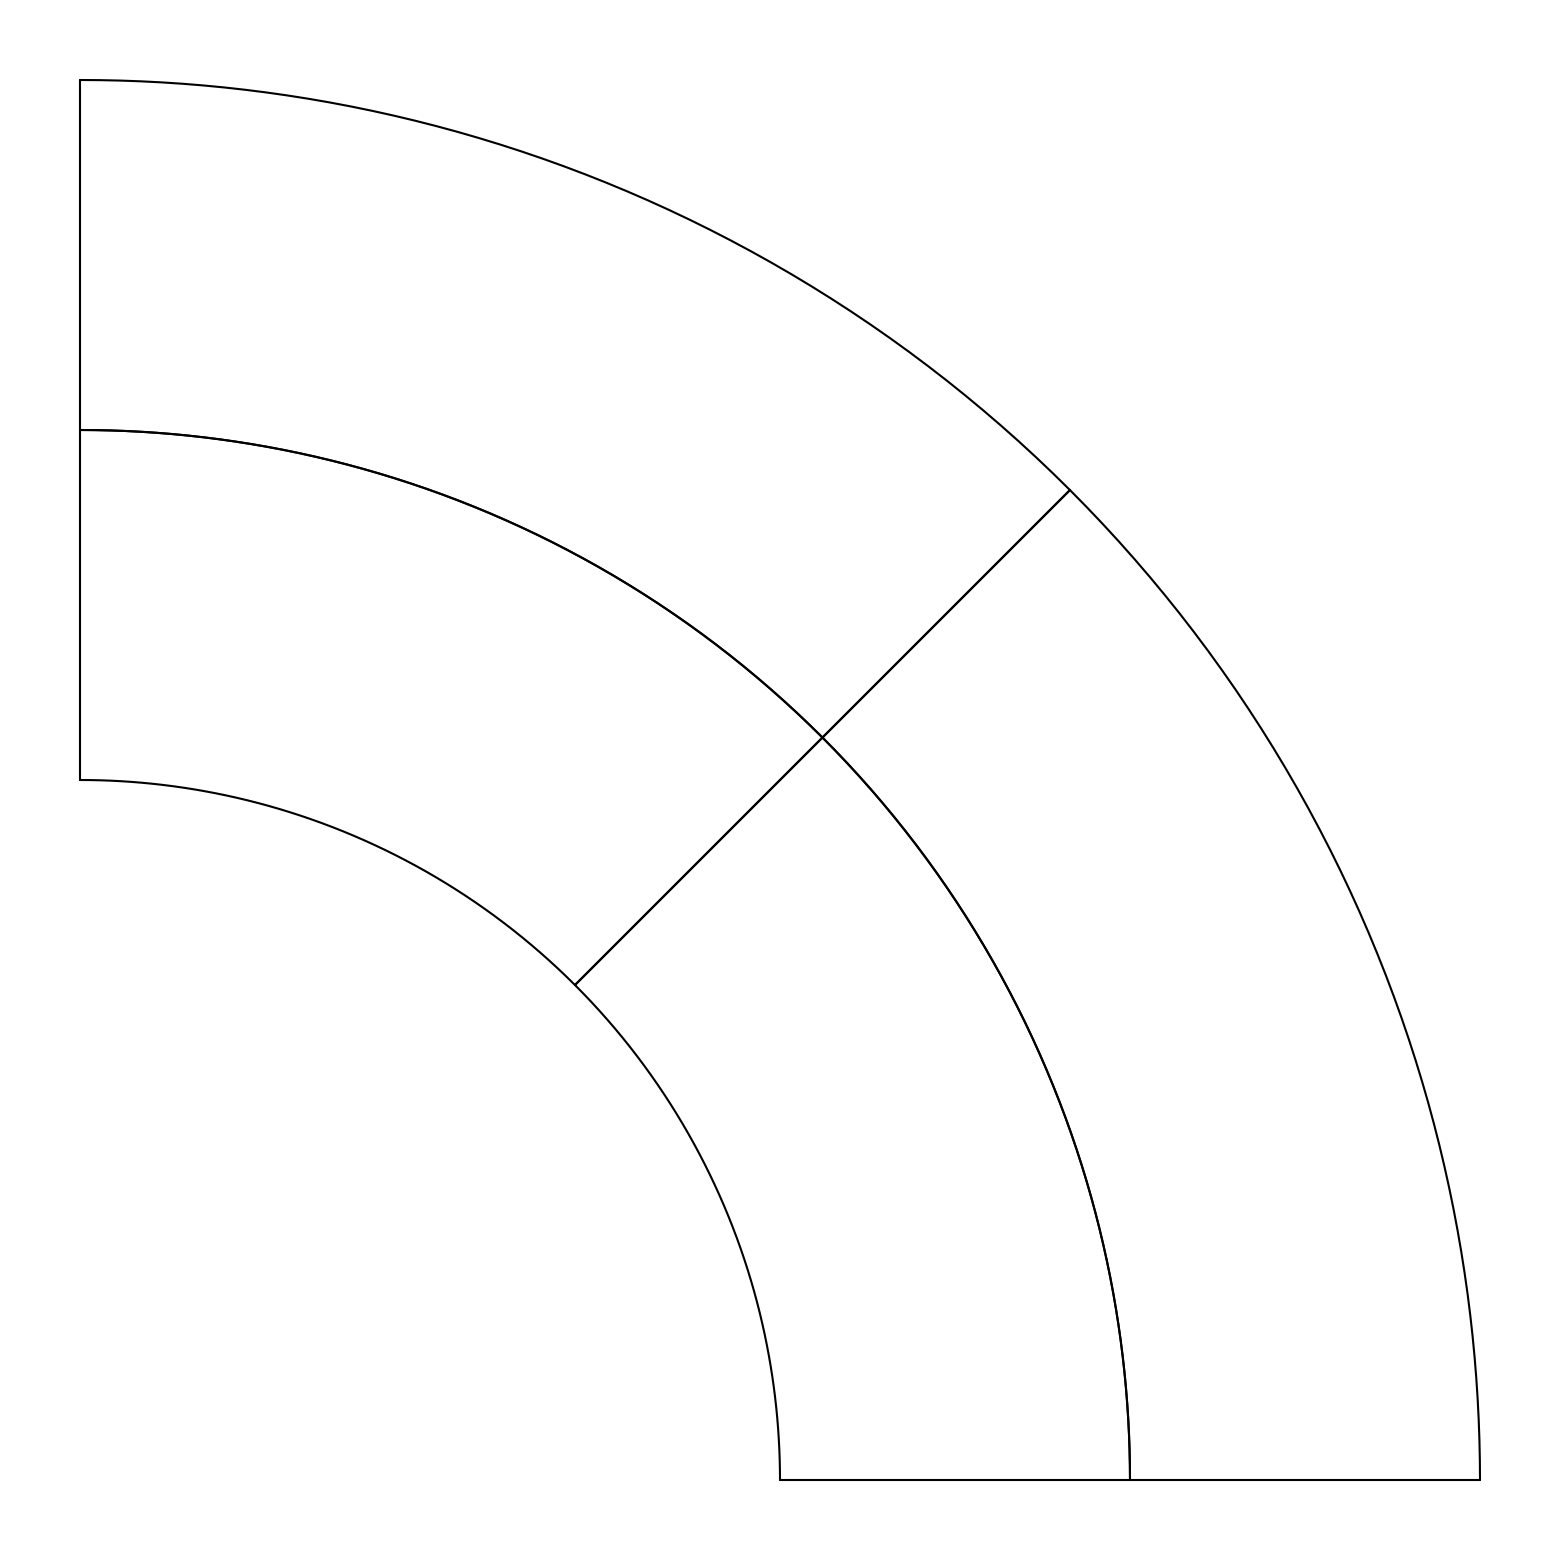

In [10]:
degs = (4,)
maxiter=2
R = np.zeros((maxiter,4*len(degs)))
for i,deg in enumerate(degs):
    N = deg+1
    M = Inductor(deg,N)
    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiter):
        print(k)
        n_p = MP.numpatches
        M.draw(figsize=(20,20),color={'C1':'yellow', 'C2':'yellow', 'Fe':'darkgrey', 'Air':'white'}, knots=0, bwidth=0.01)
        plt.axis('off');
        plt.axis('scaled');
        plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
        plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        ### IETI Mapper
        IMap = IetiMapper(M, dir_data)
        A, RHS = IMap.assemble(a=nu,f=j)
        N = [A.shape[0] for A in A]
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=True)

        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        ### Set up primal system
        primal = PrimalSystem(IMap.nodes_as_primals())
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symmetric=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        F, b = I.SchurComplement(), I.RHSforSchurComplement()

        #lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=True, rtol=1e-6, atol=1e-12)
        
        SD.setupSelectionScaling(a=nu)
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)

        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate([IMap.BCRestr[p].complete(u) if p in IMap.BCRestr else u for p,u in enumerate(u)])
        print(len(u))
        MP.plot(u)

        err_ind=adaptive.mp_resPois(MP,u,a=nu, f=j, M=MaT)

        marked_patches = adaptive.doerfler_mark(err_ind, theta=0.9, TOL=0)
        marked_patches = {p:None for p in marked_patches}

        M.h_refine(patches=marked_patches,ref="rs");

        print("#####################################################")

In [16]:
def Heat_annulus(deg, N):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.quarter_annulus(),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine()

    M.set_domain_id({1:{0}})
    return M

In [15]:
def consistency_split(MP, a):
    patches_to_split = {}
    for (p1,b1) in MP.L_intfs:
        if len(MP.L_intfs[(p1,b1)])==2:
            p2 = MP.L_intfs[(p1,b1)][0][0]
            if a[MP.mesh.patch_domains[p1]]<a[MP.mesh.patch_domains[p2]]:
                patches_to_split[p1]=None
    return patches_to_split

In [25]:
f={0:lambda x,y: 100., 1:lambda x,y: 100.}
a = {0:1.,1:1e4}
dir_data = {0:0}

In [79]:
degs = (2,3,5,8)
maxiter=10
R = np.zeros((maxiter,4*len(degs)))
for i,deg in enumerate(degs):
    N = deg+1
    M = Heat_annulus(deg,N)
    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiter):
        print(k)
        #n_p = MP.numpatches
        # M.draw(figsize=(5,5),color={1:'yellow',0:'white'}, knots=1, bwidth=0.01, patch_idx=1)
        # plt.axis('off');
        # plt.axis('scaled');
        # #plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
        # plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        ### IETI Mapper
        IMap = IetiMapper(M, dir_data)
        A, RHS = IMap.assemble(a=a,f=f)
        N = [A.shape[0] for A in A]
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)

        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        ### Set up primal system
        primal = PrimalSystem(IMap.nodes_as_primals())
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symmetric=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        F, b = I.SchurComplement(), I.RHSforSchurComplement()

        #lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=True, rtol=1e-6, atol=1e-12)
        
        #SD.setupSelectionScaling(a=a)
        P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P, output=True, rtol=1e-6, atol=1e-12)

        R[k,4*i]  = MP.numpatches
        R[k,4*i+1] = MP.N_ofs[-1]
        R[k,4*i+2]= abs(max_eig/min_eig)
        R[k,4*i+3]= it

        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate([IMap.BCRestr[p].complete(u) if p in IMap.BCRestr else u for p,u in enumerate(u)])
        #print(len(u))
        #MP.plot(u)

        err_ind=adaptive.mp_resPois(MP,u,a=a, f=f)

        marked_patches = adaptive.doerfler_mark(err_ind, theta=0.9, TOL=0)
        marked_patches = {p:None for p in marked_patches}

        M.h_refine(patches=marked_patches,ref="rs");
        MP = assemble.Multipatch(M, automatch=True)
        
        # marked_patches = consistency_split(MP)
        # M.h_refine(patches=marked_patches,ref="rs");
        # MP = assemble.Multipatch(M, automatch=True)
        
        print("#####################################################")
np.savetxt('IETI_adaptive_edge.txt', R, fmt=len(degs)*('%d','%1.2e', '%1.3f','%d'), delimiter = ' & ', newline='\\\\\n')
#np.savetxt('IETI_adaptive_selection.txt', R, fmt=len(degs)*('%d', '%1.2e', '%1.3f','%d'),delimiter = ' & ', newline='\\\\\n')
#np.savetxt('IETI_adaptive_selection_consistency.txt', R, fmt=len(degs)*('%d', '%1.2e', '%1.3f','%d'),delimiter = ' & ', newline='\\\\\n')

setting up constraints took 0.012381315231323242 seconds.
Basis setup took 0.0037136077880859375 seconds
deg = 2
0
setting up constraints took 0.011928558349609375 seconds.
Basis setup took 0.003948211669921875 seconds
pcg with preconditioned condition number κ ~ 2.393472823904742 stopped after 7 iterations with relres 2.2787361828775655e-08 after 0.0022644996643066406 seconds.
Residual contributions took 0.03435945510864258 seconds.
Jump contributions took 0.03076338768005371 seconds.
setting up constraints took 0.03662848472595215 seconds.
Basis setup took 0.00255584716796875 seconds
#####################################################
1
setting up constraints took 0.036339759826660156 seconds.
Basis setup took 0.0022606849670410156 seconds
pcg with preconditioned condition number κ ~ 6.05042980376718 stopped after 14 iterations with relres 3.799900997402126e-07 after 0.019454002380371094 seconds.
Residual contributions took 0.14502882957458496 seconds.
Jump contributions took 0.171

In [58]:
C[2].toarray()

array([[0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.16667, 0.     , 0.     , 0.     , 0.     , 0.     , 0.66667, 0.     , 0.     , 0.     , 0.     , 0.     , 0.16667, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 1.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.16667, 0.66667, 0.16667, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ]])

In [28]:
SD.prec()

Convergence condition: 5.163977794943222


<404x404 SumOperator with dtype=float64>

In [30]:
primal.Prim

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 120 stored elements and shape (1512, 30)>

In [31]:
SD.prec()

<617x617 SumOperator with dtype=float64>

In [33]:
len(b)

617